# Personal Finance Machine Learning

**Joshua Kim - Springboard Data Science Career Track**

The goal of this notebook is to create a topic modeling system that can generate topics based on the text in each post on /r/personalfinance.

## Topic Modeling

As the phrase suggests, topic modeling is using collection of texts to find hidden patterns and re-structuring those words such that we can "create" topics. The way it works is very similar to the concept of clustering in unsupervised learning problems. Without using any of the given topics from the dataset, we will use machine learning algorithms to discover groups of similar words/examples within each text post, resulting in different clusters. The issue with the current topics in place is that some may not be that relevant while others may be too similar to one another (like a multi-collinearity), resulting in repetitive topics. Of course, there are no guarantees that the generated topics will be any better than the topics currently used by /r/personalfinance but it will certainly be interesting to observe the trends that show up. 

The main type of model we will be using to create these topics is Latent Dirichlet Allocation (or LDA for short). It was first conceived and written about in the paper "Latent Dirichlet Allocation" by David Blei, Andrew Ng, and Michael I. Jordan in 2003. 

Here is the link to their website: http://jmlr.csail.mit.edu/papers/v3/blei03a.html

LDA is a generative probabilistic model that automatically discovers topics using the mappings of documents and their respective words. It works by assigning each document with a mixture of topics and each topic has an assortment of different words. We begin by randomly assigning topics to each document and have the model "learn" over time if those topics are indeed correctly assigned based on their word distributions. 

Here is a link to a great introduction to LDA: http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/

There are going to be **two** parts in this notebook:

- The first part will be to generate the topics using LDA and then labeling each document with a main topic based on their topic distributions. This is an unsupervised task.

- The second part will be to predict the topic for each post using train-test-split and text classification. This is a supervised classification task.

It should be noted that there are 2 popular open-source packages that provide LDA models: Gensim and Sci-kit Learn. For this project, we will be using Gensim to create the topics because it is more intuitive and has been around for a longer time. However, that is not to say sci-kit learn's version of LDA is not worth using. It does offer the opportunity to incorporate the fit_transform method as well as the ability to use grid-search CV, which would be great for performing hyper-parameter tuning.

The way the topic-modeling process for each model will be structured is as follows:

- 1) Import the relevant libraries and packages.


- 2) Create the necessary features.


- 3) Create the hyper-parameter tuning pipeline.


- 4) Build the Latent Dirichlet Allocation model.


- 5) Evaluate the model.


### Part 1: Creating the Topics

**1) Import relevant libraries and packages**

In [2]:
# Standard libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
from IPython.display import display

# Gensim library for LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Spacy for lemmatization
import spacy

# pyLDAvis for LDA visualization
import pyLDAvis
import pyLDAvis.gensim 

# Sci-kit learn packages
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB

# Import the data
from pf_files import *

# Pickle for savings files for later use
import pickle

# Get rid of the warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\Users\Joshua\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\Joshua\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


**2) Feature Engineering**

Before we begin creating the pipeline and models, we will need to first create the features that we will be inputting into the LDA model. We do this by using a bag-of-words model which assigns each token an id number and also counts the frequency of a token in each text (document).

In [51]:
# We will be using the lemmatized_text feature as the input data
dataset = df.lemmatized_text

# Phrases need to show up a minimum of 5 times and threshold for the score is set at 100.
bigram = gensim.models.phrases.Phrases(dataset, min_count=5, threshold=100) 
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [52]:
# Print bigrams of the first text
print(bigram_mod[dataset[0]])

['way', 'make', 'extra', 'side', 'money']


In [53]:
# Function that returns a list of bigrams for each text.
def create_bigrams(text):
    return [bigram_mod[doc] for doc in text]

# Create the bigrams for the dataset
data_bigrams = create_bigrams(dataset)
# with open('pf_data_bigrams.pickle', 'wb') as f:
#     pickle.dump(data_bigrams, f)

# Create Dictionary 
dictionary = corpora.Dictionary(data_bigrams)
#dictionary.save('pf_dictionary.pickle')

In [54]:
# Filter out tokens that appear less than 5 times and/or appear in more than 50% of documents. This will get rid of outliers and un-important words.
dictionary.filter_extremes(no_below=5, no_above=0.5)

In [55]:
# Let's take a peek at the dictionary
count = 0
for x in dictionary.token2id.items():
    count +=1
    print(x)
    if count == 10:
        break

('extra', 0)
('make', 1)
('money', 2)
('side', 3)
('way', 4)
('blind', 5)
('go', 6)
('help', 7)
('homeless', 8)
('job', 9)


In [56]:
# Check the number of texts that were processed. It should be 10177 (since that's the number of rows).
print('Number of Documents: {}'.format(dictionary.num_docs))
# Check the number of unique tokens by calling the dictionary object
print(dictionary)

Number of Documents: 23182
Dictionary(7633 unique tokens: ['extra', 'make', 'money', 'side', 'way']...)


In [57]:
# Create a bag of words
corpus = [dictionary.doc2bow(text) for text in data_bigrams]
# with open('pf_corpus.pickle', 'wb') as f:
#     pickle.dump(corpus, f)

# View sample text and its respective bag of words transformation
print(data_bigrams[0])
print(corpus[0])

['way', 'make', 'extra', 'side', 'money']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]


While using a bag-of-words model does the job in counting the frequency of each word per document, we want to better quantify the signature words which don't appear as frequently as common words. For this reason, we will also introduce a **term frequency - inverse document frequency (tf-idf) model**. 

In [8]:
# Import the models module
from gensim import models

# Fit the bag of words into the tf-idf model
tfidf = models.TfidfModel(corpus)
# Create a new corpus using the tf-idf model
corpus_tfidf = tfidf[corpus]

In [9]:
# Take a look at the first document using the bag-of-words vectorization vs tf-idf vectorization
print(data_bigrams[0])
print(corpus[0])
print(corpus_tfidf[0])

['way', 'make', 'extra', 'side', 'money']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]
[(0, 0.5392389089986213), (1, 0.228596437753383), (2, 0.23277485092437628), (3, 0.6866754165273157), (4, 0.3622951956383253)]


**3) Create the hyper-parameter tuning pipeline using Gensim.**

While there are many different parameters used in creating gensim's LDA model, the 2 most important ones in the gensim LDA model are:

1) **number of topics (num_topics)** - The number of topics that are created from the bag-of-words

2) **alpha value (alpha)** - The alpha value controls the mixture of topics for any given document. The greater the alpha, the greater the variety of topics will appear for any given document. The lower the alpha, the lower the variety of topics.

According to Griffiths and Steyvers (2004), it is suggested to use a value of 50/k (where k is number of topics) for α. However, gensim allows us to specify 'auto' for the alpha parameter, which causes the machine to automatically estimate alpha based off of the corpus we train with. This conveniently means that we won't have to test out different alpha values.

To determine which are the best hyper-parameters, we will be evaluating each iteration of the model based on its performance on its **coherence value**. Coherence is the measure of how much a document makes sense given the context of the words in relation to each other. For example, a coherence score of 0.10 would indicate that the model did a poor job at creating topics for similar documents. 

In [9]:
# Create a function that iterates through the different number of topics and creates an LDA model for each instance
def LDA_pipeline(dictionary, corpus, texts, start, limit ,step):
    model_list = [] # Create empty list to hold the models
    coherence_values = [] # Create empty list to hold the coherence scores
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, alpha = 'auto')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

**4) Build the Latent Dirichlet Allocation model.**

Next let's build the LDA model by fitting the dictionary and corpus.

In [10]:
model_list, coherence_values = LDA_pipeline(dictionary=dictionary, corpus=corpus, texts=data_bigrams, start=2, limit=40, step=6)

# with open('pf_model_list', 'wb') as f:
#     pickle.dump(model_list, f)
# with open('pf_coherence_values', 'wb') as f:
#     pickle.dump(coherence_values, f)   

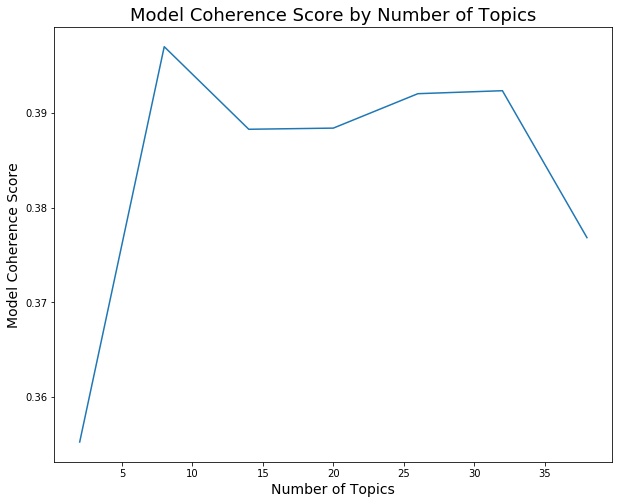

In [11]:
# Plot the coherence scores
limit=40; start=2; step=6;
x = range(start, limit, step)

plt.figure(figsize=(10,8))
plt.plot(x, coherence_values)
plt.title('Model Coherence Score by Number of Topics', fontsize = 18)
plt.xlabel("Number of Topics", fontsize = 14)
plt.ylabel("Model Coherence Score", fontsize = 14)
#plt.savefig(r'C:\Users\Joshua\Downloads\personal_finance_pics\PersonalFinance Coherence Graph', bbox_inches = 'tight')
plt.show()

In [12]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Number of Topics =", m, ", Coherence Value: ", round(cv, 4))

Number of Topics = 2 , Coherence Value:  0.3553
Number of Topics = 8 , Coherence Value:  0.397
Number of Topics = 14 , Coherence Value:  0.3883
Number of Topics = 20 , Coherence Value:  0.3884
Number of Topics = 26 , Coherence Value:  0.392
Number of Topics = 32 , Coherence Value:  0.3923
Number of Topics = 38 , Coherence Value:  0.3768


As we can see, the coherence value peaks when the number of topics is equal to 20. Let's select this model from the model list and print the topics.

In [49]:
from pprint import pprint
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.021*"college" + 0.020*"school" + 0.017*"not" + 0.014*"year" + 0.014*"pay" '
  '+ 0.013*"would" + 0.013*"get" + 0.012*"work" + 0.010*"do" + '
  '0.009*"student"'),
 (1,
  '0.055*"insurance" + 0.021*"health" + 0.017*"life" + 0.017*"plan" + '
  '0.017*"year" + 0.016*"not" + 0.013*"policy" + 0.011*"benefit" + 0.011*"do" '
  '+ 0.011*"would"'),
 (2,
  '0.025*"company" + 0.023*"offer" + 0.021*"would" + 0.020*"house" + '
  '0.016*"salary" + 0.014*"the" + 0.013*"year" + 0.012*"current" + '
  '0.009*"sell" + 0.009*"job"'),
 (3,
  '0.090*"credit" + 0.070*"card" + 0.023*"account" + 0.021*"score" + '
  '0.019*"get" + 0.017*"pay" + 0.015*"bank" + 0.014*"use" + 0.013*"not" + '
  '0.012*"balance"'),
 (4,
  '0.048*"job" + 0.036*"work" + 0.018*"year" + 0.017*"make" + 0.016*"get" + '
  '0.015*"time" + 0.014*"be" + 0.014*"not" + 0.011*"would" + 0.011*"have"'),
 (5,
  '0.036*"money" + 0.029*"saving" + 0.026*"year" + 0.019*"account" + '
  '0.018*"save" + 0.014*"invest" + 0.012*"good" + 0.011*"put

The model has generated some topics which are clearly defined such as topic 3 (loans), topic 6 (home mortgage), and topic 8 (credit cards). However other topics are more ambiguous and don't do a good job of being specific such as topic 0, topic 1, and topic 4. Besides using the coherence value, we can also use **perplexity** to measure the effectiveness of this model.

Perplexity (in the context of Natural Language Processing) describes how well the model can predict the next word. An example is if you had wanted to predict a number from 1 to 6 and you decide to use a die. In this case, the die's perplexity with this particular problem would be 6 because you would be correct in guessing the right number 1/6th of the time. In our case, the perplexity would be measuring how well the model can predict the topic based on a given text and how well it can predict a word based on a given topic. 

The closer the perplexity is to 1, the better the model is at predicting unseen data. 

In [14]:
# Compute Perplexity
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=data_bigrams, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.867150170034154

Coherence Score:  0.3883817993710729


With a perplexity absolute value of 6.9, it would be analogous to correctly predicting a number using a 7-sided die. 

In [65]:
# with open('pf_pyldavis.pickle', 'wb') as f:
#     pickle.dump(vis, f)
# vis = pd.read_pickle('pf_pyldavis.pickle')
# vis

In [66]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, dictionary)
vis

C:\Users\Joshua\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16    -0.038368  0.088166       1        1  12.614960
5      0.045948 -0.084265       2        1  10.027288
18    -0.066907 -0.043867       3        1   9.723760
3      0.017819  0.117111       4        1   8.195521
4     -0.028707 -0.045783       5        1   7.745468
10     0.014935  0.182867       6        1   6.404721
8     -0.078295 -0.010573       7        1   5.475188
2     -0.018336 -0.077663       8        1   4.430164
12    -0.006647 -0.049893       9        1   4.400032
0     -0.015330 -0.024978      10        1   4.198516
11    -0.101606 -0.045300      11        1   4.093831
9      0.181794 -0.115881      12        1   3.932869
15     0.083307  0.058827      13        1   3.753462
14    -0.135852 -0.112141      14        1   3.001493
1      0.025933  0.010571      15        1   2.914178
6      0.217205 -0.010559      16        1   2.840708
19     0.020366  0.022874      17        1   2.182925
17    -0.103471  0.048470      18        1   1.873143
13    -0.025390  0.079738      19        1   1.196914
7      0.011601  0.012278      20        1   0.994864, topic_info=     Category          Freq        Term         Total  loglift  logprob
term                                                                   
117   Default  15390.000000      credit  15390.000000  30.0000  30.0000
19    Default  10052.000000         car  10052.000000  29.0000  29.0000
114   Default  10159.000000        card  10159.000000  28.0000  28.0000
169   Default  11828.000000        loan  11828.000000  27.0000  27.0000
466   Default   7101.000000         tax   7101.000000  26.0000  26.0000
377   Default   5617.000000        fund   5617.000000  25.0000  25.0000
453   Default   3938.000000         ira   3938.000000  24.0000  24.0000
165   Default   5014.000000   insurance   5014.000000  23.0000  23.0000
51    Default  10158.000000     account  10158.000000  22.0000  22.0000
461   Default   2888.000000        roth   2888.000000  21.0000  21.0000
9     Default   9214.000000         job   9214.000000  20.0000  20.0000
73    Default  20564.000000         pay  20564.000000  19.0000  19.0000
301   Default   2840.000000        cash   2840.000000  18.0000  18.0000
126   Default   7499.000000     payment   7499.000000  17.0000  17.0000
50    Default  10462.000000        work  10462.000000  16.0000  16.0000
11    Default  13432.000000       month  13432.000000  15.0000  15.0000
244   Default   5044.000000     student   5044.000000  14.0000  14.0000
58    Default   8692.000000        debt   8692.000000  13.0000  13.0000
221   Default   5241.000000       house   5241.000000  12.0000  12.0000
132   Default   3422.000000       score   3422.000000  11.0000  11.0000
179   Default  22179.000000         not  22179.000000  10.0000  10.0000
300   Default   5342.000000         buy   5342.000000   9.0000   9.0000
77    Default   6160.000000      saving   6160.000000   8.0000   8.0000
517   Default   5202.000000     company   5202.000000   7.0000   7.0000
1304  Default   2861.000000    mortgage   2861.000000   6.0000   6.0000
210   Default   2344.000000      budget   2344.000000   5.0000   5.0000
1013  Default   2200.000000       stock   2200.000000   4.0000   4.0000
107   Default   2783.000000  retirement   2783.000000   3.0000   3.0000
238   Default   2903.000000      school   2903.000000   2.0000   2.0000
135   Default   6469.000000         use   6469.000000   1.0000   1.0000
...       ...           ...         ...           ...      ...      ...
301   Topic20    733.164917        cash   2840.345215   3.2560  -3.0235
4697  Topic20     63.610096        wire    105.366486   4.1056  -5.4681
2785  Topic20     38.995514    shipping     53.566895   4.2928  -5.9574
1514  Topic20     55.123249     english     91.297836   4.1058  -5.6113
2452  Topic20     42.147758       acorn     62.319901   4.2192  -5.8797
1250  Topic20     84.385872  calc

Because many of the topics are overlapping, this is a sign that they are not good at being specific and identifiable. Also notice that most of the topics are relatively smaller in scale which indicates that the set of words in each topic are shared among other topics. A good model is typically one that is made up of large, non-overlapping topics that are well spread out among the axis. 

Let's try using **MALLET**, which is a Java-based package used for a variety of NLP purposes such as topic modelling. It often does a better job of generating a good quality of topics. 

Note: One downside is that we will not be able to use the pyLDAvis tool so we will not be able to visualize the topics.

In [16]:
import os
os.environ.update({'MALLET_HOME': r'C:\Users\Joshua\Downloads\mallet-2.0.8\mallet-2.0.8', 'JAVA_HOME': r'C:\Program Files (x86)\Java\jdk1.8.0_131'})

mallet_path = 'C:\\Users\\Joshua\\Downloads\\mallet-2.0.8\\mallet-2.0.8\\bin\\mallet'

In [17]:
def MALLET_pipeline(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [18]:
MALLET_model_list, MALLET_coherence_values = MALLET_pipeline(dictionary=dictionary, corpus=corpus, texts=data_bigrams, start=2, limit=40, step=6)

# with open('pf_mallet_model_list', 'wb') as f:
#     pickle.dump(MALLET_model_list, f)
# with open('pf_mallet_coherence_values', 'wb') as f:
#     pickle.dump(MALLET_coherence_values, f)

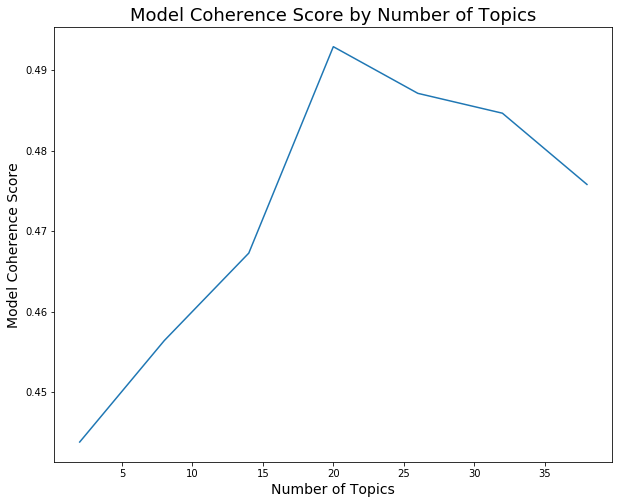

In [19]:
# Plot the coherence scores
limit=40; start=2; step=6;
x = range(start, limit, step)

plt.figure(figsize=(10,8))
plt.plot(x, MALLET_coherence_values)
plt.title('Model Coherence Score by Number of Topics', fontsize = 18)
plt.xlabel("Number of Topics", fontsize = 14)
plt.ylabel("Model Coherence Score", fontsize = 14)
#plt.savefig(r'C:\Users\Joshua\Downloads\personal_finance_pics\PersonalFinance Coherence Graph1', bbox_inches = 'tight')
plt.show()

In [20]:
# Print the coherence scores
for m, cv in zip(x, MALLET_coherence_values):
    print("Number of Topics =", m, ", Coherence Value: ", round(cv, 4))

Number of Topics = 2 , Coherence Value:  0.4438
Number of Topics = 8 , Coherence Value:  0.4564
Number of Topics = 14 , Coherence Value:  0.4673
Number of Topics = 20 , Coherence Value:  0.4929
Number of Topics = 26 , Coherence Value:  0.4871
Number of Topics = 32 , Coherence Value:  0.4847
Number of Topics = 38 , Coherence Value:  0.4758


As we can see, using the LDA Mallet topic modeling toolkit has much better results. Whereas gensim's built-in LDA algorithm resulted in mostly coherence values dangling in the mid-high 0.30s, using MALLET resulted in a peak coherence value of nearly 0.5. Choosing 8 as the number of topics results in a coherence score of 0.4961 so let's go with that and see what kind of topics are created by the model.

In [21]:
# Select the model and print the topics
MALLET_test_model = MALLET_model_list[1]
pprint(MALLET_test_model.print_topics(num_words=10))

[(0,
  '0.070*"money" + 0.043*"saving" + 0.035*"save" + 0.034*"month" + '
  '0.028*"start" + 0.022*"expense" + 0.020*"school" + 0.020*"college" + '
  '0.017*"spend" + 0.016*"make"'),
 (1,
  '0.040*"house" + 0.036*"home" + 0.034*"year" + 0.033*"move" + 0.031*"live" + '
  '0.025*"rent" + 0.023*"buy" + 0.021*"mortgage" + 0.017*"sell" + '
  '0.015*"wife"'),
 (2,
  '0.066*"work" + 0.064*"job" + 0.028*"company" + 0.025*"time" + 0.021*"offer" '
  '+ 0.021*"make" + 0.018*"week" + 0.016*"salary" + 0.016*"hour" + '
  '0.012*"year"'),
 (3,
  '0.076*"car" + 0.037*"insurance" + 0.016*"buy" + 0.013*"cost" + '
  '0.012*"month" + 0.012*"good" + 0.011*"time" + 0.010*"finance" + '
  '0.010*"life" + 0.010*"cover"'),
 (4,
  '0.146*"pay" + 0.093*"loan" + 0.065*"debt" + 0.056*"payment" + 0.053*"month" '
  '+ 0.039*"year" + 0.039*"student" + 0.034*"interest" + 0.028*"make" + '
  '0.024*"rate"'),
 (5,
  '0.131*"credit" + 0.087*"card" + 0.067*"account" + 0.037*"bank" + '
  '0.028*"score" + 0.025*"good" + 0.020

Although we can see that having 8 as the number of topics produces the best coherence score, it will generalize many of the different topics and thus it would be better to use a higher number. 

Let's select 20 as the number of topics since that has the second highest coherence value in the list at 0.4867.

In [22]:
# Select the model and print the topics
MALLET_optimal_model = MALLET_model_list[3]
MALLET_model_topics = MALLET_optimal_model.show_topics(formatted=False)
pprint(MALLET_optimal_model.print_topics(num_words=10))

[(0,
  '0.087*"move" + 0.080*"live" + 0.040*"rent" + 0.036*"parent" + 0.029*"place" '
  '+ 0.024*"family" + 0.024*"apartment" + 0.021*"find" + 0.021*"mom" + '
  '0.019*"dad"'),
 (1,
  '0.053*"make" + 0.047*"good" + 0.046*"feel" + 0.033*"lot" + 0.033*"thing" + '
  '0.029*"financial" + 0.026*"life" + 0.026*"money" + 0.023*"pretty" + '
  '0.018*"idea"'),
 (2,
  '0.047*"call" + 0.034*"receive" + 0.026*"send" + 0.026*"charge" + '
  '0.019*"report" + 0.017*"collection" + 0.014*"email" + 0.014*"claim" + '
  '0.013*"check" + 0.013*"letter"'),
 (3,
  '0.107*"year" + 0.059*"school" + 0.054*"college" + 0.035*"start" + '
  '0.032*"student" + 0.025*"graduate" + 0.023*"work" + 0.021*"time" + '
  '0.018*"make" + 0.017*"job"'),
 (4,
  '0.140*"work" + 0.118*"job" + 0.073*"pay" + 0.069*"week" + 0.068*"time" + '
  '0.042*"hour" + 0.034*"day" + 0.030*"make" + 0.021*"full" + 0.020*"start"'),
 (5,
  '0.037*"give" + 0.024*"find" + 0.021*"edit" + 0.019*"thing" + 0.018*"guy" + '
  '0.015*"number" + 0.015*"pers

With MALLET, we can better identify topics in the model such as topic 0 (school), topic 2 (monthly expenses), topic 5 (home mortgage), topic 9 (investments), topic 12 (credit card), topic 14 (loans). 

However, we can also see that some of the topics, such as topic 5, are very ambiguous in their words. For example, the word "give" and "find" are the 2 most heavily weighted words in topic 5 but they can easily be found in any post regardless of the subject. This would mean that a post would be categorized under topic 5 even if the subject of the post was about cars or bills.

There is no simple way to select the appropriate topic name for each LDA-generated topic, but here are a few ideas:

- 1) Look at the top 10-20 words for each topic and create a topic name/theme based on your own experience. In other words, aggregate them and select a fitting name.

- 2) Use the first or second most heavily weighted word in each topic as the topic name.

- 3) You can also run the model multiple times and aggregate them to select the proper name using either the first or second methods. 

Note: these methods would become much more difficult for cases where you have upwards of 30 topics.

Let's use the first method to assign a topic name for each generated topic. Since quite a few of the topics are not coherent, we will categorize them under 'other'.

In [27]:
new_topics = {
    0: 'housing',
    1: 'other',
    2: 'collections',
    3: 'school',
    4: 'employment',
    5: 'other',
    6: 'credit card',
    7: 'auto',
    8: 'taxes',
    9: 'other',
    10: 'debt',
    11: 'investment',
    12: 'bank account',
    13: 'employment',
    14: 'budgeting',
    15: 'loans',
    16: 'other',
    17: 'insurance',
    18: 'housing',
    19: 'planning' 
}

To quickly demonstrate how this would work, let's use an example.

In [24]:
# Example
print('Sample Document: ',''.join(df.text[10]))
for index, score in sorted(MALLET_optimal_model[corpus[10]], key=lambda tup: -1*tup[1])[:3]:
    print("\nScore: {}\t \nTopic {}: {}".format(score, index ,MALLET_optimal_model.print_topic(index, 10)))

Sample Document:  Please help me review my budget . . underpaid tech worker in SF. Thanks 

Score: 0.09393939393939396	 
Topic 13: 0.085*"company" + 0.056*"offer" + 0.041*"salary" + 0.034*"job" + 0.026*"position" + 0.025*"current" + 0.024*"work" + 0.020*"raise" + 0.016*"experience" + 0.014*"year"

Score: 0.06363636363636366	 
Topic 4: 0.140*"work" + 0.118*"job" + 0.073*"pay" + 0.069*"week" + 0.068*"time" + 0.042*"hour" + 0.034*"day" + 0.030*"make" + 0.021*"full" + 0.020*"start"

Score: 0.06363636363636366	 
Topic 14: 0.141*"month" + 0.051*"expense" + 0.040*"spend" + 0.036*"budget" + 0.033*"monthly" + 0.029*"income" + 0.021*"rent" + 0.021*"food" + 0.017*"gas" + 0.015*"total"


We would classify this post under "debt" since it falls under topic 13, which we labeled as 'debt'. 

Now that we have created the topics, let's actually assign the topics to each post. The way the LDA model works in gensim is that each document is assigned a portion of multiple topics rather than a single one. Therefore, the most simple way of picking a topic for a given post is to select whichever topic has the greatest topic percentage contribution.

In [25]:
def topic_assignment(model, corpus, text):
    # Create empty dataframe
    topics_df = pd.DataFrame()

    # Get main topic in each document
    for n, row in enumerate(model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Main topic, Percent Contribution and Keywords for each document
        for j, (topic_num, perc_topic) in enumerate(row):
            # We only want the main topic
            if j == 0:   
                wp = model.show_topic(topic_num) # returns the topic words and proportion of each word
                topic_keywords = ", ".join([word for word, prop in wp])
                # Append the Topic number, Proportion of Contribution and the Topic Keywords for each row
                topics_df = topics_df.append(pd.Series([int(topic_num), round(perc_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    topics_df.columns = ['Main_Topic', 'Topic_Proportion', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(text)
    topics_df = pd.concat([topics_df, contents], axis=1)
    return(topics_df)


df_topics = topic_assignment(model=MALLET_optimal_model, corpus=corpus, text=df.text)

# Format
df_main_topic = df_topics.reset_index()
df_main_topic.columns = ['Doc_Number', 'Main_Topic', 'Topic_Proportion', 'Keywords', 'Text']

Now that we have assigned each document with their respective generated topic number, let's map each document's topic number to the topic names that we created.

In [28]:
# Create a function that maps each topic number to its topic name
def map_topic(topics):
    for topic_num in topics:
        yield(new_topics[topic_num])

# Create list of topic names from the generator
topic_list = list(map_topic(df_main_topic['Main_Topic']))

# Create new column using the topic list
df_main_topic['Topic_Names'] = topic_list

# with open('pf_df_main_topic', 'wb') as f:
#     pickle.dump(df_main_topic, f)

In [29]:
# Show
df_main_topic[:10]

,Doc_Number,Main_Topic,Topic_Proportion,Keywords,Text,Topic_Names
0,0,19.0,0.0772,"money, year, save, saving, put, start, plan, e...",Ways to make extra side money?,planning
1,1,0.0,0.0718,"move, live, rent, parent, place, family, apart...","(Year UPDATE) Legally blind, going homeless, h...",housing
2,2,4.0,0.1090,"work, job, pay, week, time, hour, day, make, f...","19, being kicked out So i just found out last ...",employment
3,3,12.0,0.1172,"account, bank, money, check, open, transfer, f...",Online Savings Account? Hello! Looking for rec...,bank account
4,4,14.0,0.0710,"month, expense, spend, budget, monthly, income...",Tools for Managing Incomes and Expenses,budgeting
5,5,9.0,0.1087,"question, make, personal, finance, post, busin...","With resources like reddit, is financial consu...",other
6,6,6.0,0.1568,"credit, card, score, balance, apply, limit, bu...","Credit hit from late payment, fee was waiver, ...",credit card
7,7,15.0,0.1966,"loan, pay, debt, payment, interest, student, r...",Need Help budgetting/getting out of debt Long ...,loans
8,8,4.0,0.1411,"work, job, pay, week, time, hour, day, make, f...","22yo M I'm a 22 year old male, with an almost ...",employment
9,9,2.0,0.0770,"call, receive, send, charge, report, collectio...","Debt collector gave 2 hours to pay, yelled, sa...",collections


Now that we have assigned a topic to each text, let's further analyze the different topics through visualization.

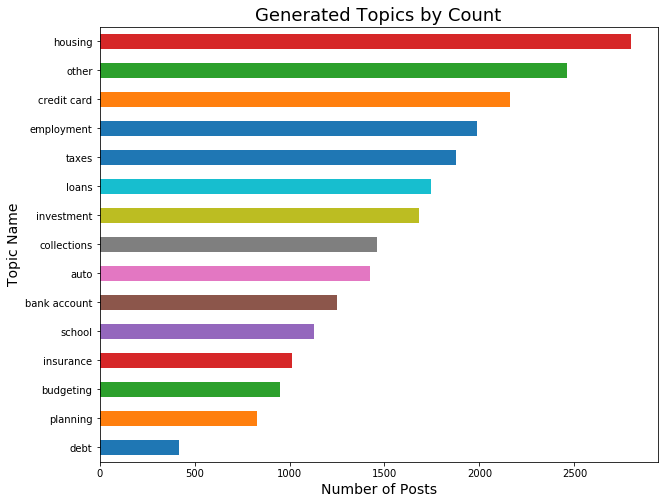

In [30]:
df_main_topic['Topic_Names'].value_counts(ascending=True).plot(kind='barh', figsize = (10,8))
plt.title('Generated Topics by Count', fontsize = 18)
plt.xlabel('Number of Posts', fontsize = 14)
plt.ylabel('Topic Name', fontsize=14)
plt.savefig(r'C:\Users\Joshua\Downloads\personal_finance_pics\PersonalFinance Generated Topic Count', bbox_inches = 'tight')
plt.show()

In [31]:
# Compute proportion of 'other' posts
len(df_main_topic[df_main_topic['Topic_Names'] == 'other'])/len(df_main_topic)

0.10624622551979984

Other, Investments and Credit Cards are the 3 most common topics in terms of number of posts. An astounding 14% of all posts are classified under 'other', which could imply that these were bad classifications. With a coherence value of 0.4867, it certainly makes sense that certain topics are more "generalized" than others. In the original topics, 'other' was the 2nd largest topic by number of posts so it is not too far off. 

On the flip side, Saving, Bills, and Debt are the 3 least common topics. This is unusual since debt was THE most common topic in the original topics as dictated by /r/personalfinance. This could be due to a few different reasons:

- 1) Redditors classified their posts as 'Debt' without actually being about debt. In other words, it could be the case that there are many false positives in the original classification.

- 2) Redditors classified their posts as 'Debt' but the posts had stronger semblance to other topics. For example the new generated topic 'school' could also include debt as part of student loans.

- 3) Some of the new generated topics could also contain debt as a significant contributer while being labeled under a different topic. For example, the 'other' topics could very well have had many of the original 'Debt' posts.

- 4) Neither the original topics nor the LDA MALLET model have done a good job of determining which posts are about the topic 'Debt'. 

Next, let's take a look at each topic's most representative post. In other words, which post had the highest document-topic percent contribution for each topic? 

In [32]:
# Create empty dataframe 
df_ = pd.DataFrame()

# Groupby topic names on df_main_topic
df_names_grouped = df_main_topic.groupby('Topic_Names')

# Iterate through the groupby object and take the text with the highest topic proportion for each topic
for i, grp in df_names_grouped:
    df_ = pd.concat([df_, grp.sort_values(['Topic_Proportion'], ascending=[0]).head(1)],axis=0)

# Reset Index    
df_.reset_index(drop=True, inplace=True)

# Show
df_.drop(['Doc_Number', 'Main_Topic'], axis=1)

,Topic_Proportion,Keywords,Text,Topic_Names
0,0.4425,"car, buy, vehicle, finance, drive, lease, paym...",Honda CRV 2007 When to sell vs repair? Have a ...,auto
1,0.4486,"account, bank, money, check, open, transfer, f...",Is there any real reason to still use a brick ...,bank account
2,0.3810,"month, expense, spend, budget, monthly, income...",Those Looking to Create a Budget I've been rea...,budgeting
3,0.5010,"call, receive, send, charge, report, collectio...",[Debt x-post r/legaladvice] Apartment sent me ...,collections
4,0.4496,"credit, card, score, balance, apply, limit, bu...",Trying to understand how to efficiently utiliz...,credit card
5,0.2387,"pay, back, make, month, time, end, due, lose, ...","At the end of my rope, nearing bankruptcy... G...",debt
6,0.4718,"company, offer, salary, job, position, current...",Need Career Advice: Ask for pay increase that ...,employment
7,0.3824,"house, home, buy, mortgage, year, sell, proper...",Seller agreed to replace HVAC. Could there be ...,housing
8,0.6089,"insurance, bill, pay, plan, health, cover, med...",My wife is getting insurance and I am a little...,insurance
9,0.7426,"fund, invest, investment, stock, market, vangu...","Advice for 401k investment Hi pf gurus,\n\nI a...",investment


In [33]:
print('Mean: ',np.mean(df_['Topic_Proportion']))
print('Median: ', np.median(df_['Topic_Proportion']))

Mean:  0.45143333333333335
Median:  0.4496


There are a few note-worthy things here:

1) The topics with the highest document-topic proportion rates were investment (60.01%), taxes (46.58%) and loans (46.25%).

2) The topics with the lowest max document-topic proportion rates were savings (22.19%), debt (24.37%) and expenses (30.84%). Considering the fact that debt and savings were among the bottom 3 topics in terms of document count, this could be the cause for that. Perhaps the algorithm did not do a good job in forming a topic surrounding posts about debt OR other topics contained posts about debt.

3) The mean of the maximum document-topic proportion rates for the topics is 38.82% and the median is 38.88%. 

Let's now create a summary table of the generated topics. 

In [34]:
# Number of Documents for Each Topic
topic_counts = df_main_topic['Topic_Names'].value_counts() #Returns series of topic names by count
topic_counts_ = topic_counts.reset_index() # Reset index to create a dataframe
topic_counts_.columns = ['Topic_Names', 'Num_Documents'] # Rename columns

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4) # Returns series of topic names by proportion of documents
topic_contribution = topic_contribution.reset_index()
topic_contribution.columns = ['Topic_Names', 'Perc_Documents']

# Topic Number and Keywords
x = df_[['Topic_Names', 'Keywords']] # Returns keywords 

# Merge the dataframes
df_main_topics = topic_contribution.merge(topic_counts_, on='Topic_Names').merge(x, on='Topic_Names')

# Show
df_main_topics.sort_values(by = 'Num_Documents', ascending = False) # Sort by number of documents

,Topic_Names,Perc_Documents,Num_Documents,Keywords
0,housing,0.1207,2798,"house, home, buy, mortgage, year, sell, proper..."
1,other,0.1062,2463,"give, find, edit, thing, guy, number, person, ..."
2,credit card,0.0931,2159,"credit, card, score, balance, apply, limit, bu..."
3,employment,0.0858,1989,"company, offer, salary, job, position, current..."
4,taxes,0.0811,1879,"tax, ira, roth, income, year, retirement, cont..."
5,loans,0.0753,1746,"loan, pay, debt, payment, interest, student, r..."
6,investment,0.0725,1680,"fund, invest, investment, stock, market, vangu..."
7,collections,0.0630,1461,"call, receive, send, charge, report, collectio..."
8,auto,0.0614,1423,"car, buy, vehicle, finance, drive, lease, paym..."
9,bank account,0.0539,1250,"account, bank, money, check, open, transfer, f..."


### Part 2: Predicting the data

**5) Evaluate the model.**

In the first part of this project, we used the gensim's LDA and LDA MALLET algorithms to generate new topics for the /r/personalfinance posts. We also used perplexity and coherence scores as a way to measure how effective the models were at capturing the sensibility of the new topics. However, these metrics only do a good job of evaluating the data that was already fitted into the model. If we were to use new data and try to evaluate those using perplexity and coherence, it would also have to include the training data and this would be an issue since it would mean that we are transforming both training and testing data at the same time. Therefore we will need to find another evaluation method, which is why we will instead be transforming the problem into a **classification**-type problem.

By using our new generated topics as the target variables, we will use the text as the feature variables and try to predict the labels for new data. By measuring the accuracy, precision and recall of the predictions we will be able to determine how reasonable and logical the topics are. For example, if it turns out that many of the posts labeled as 'school' were indeed predicted as 'school', our model would have done a good job of capturing most of the school-related posts into a single cluster.

Before we begin, let's first add the new topics to the original dataset so that we can perform feature extraction for the classification task.

In [39]:
# Reset index so that we can merge on index numbers
df_reset = df.reset_index()[['index' ,'text', 'topic', 'clean_text']]

# Merge on index numbers
df_eval = df_reset.merge(df_main_topic[['Topic_Names', 'Doc_Number']], left_on = 'index', right_on = 'Doc_Number')
# Drop index numbers
df_eval.drop(['index', 'Doc_Number'], axis=1, inplace = True)
# Rename columns
df_eval.columns = ['text', 'old_topic', 'clean_text', 'new_topic']
# Take a peek
df_eval.head()

#df_eval.to_csv(r'C:\Users\Joshua\Downloads\Data\reddit\reddit_pf5.csv')
#df_eval.to_pickle(r'C:\Users\Joshua\Pickle_files\df_eval')
#df_eval = pd.read_pickle(r'C:\Users\Joshua\Pickle_files\df_eval')

,text,old_topic,clean_text,new_topic
0,Ways to make extra side money?,unknown,ways make extra side money,planning
1,"(Year UPDATE) Legally blind, going homeless, h...",Other,year update legally blind going homeless one j...,housing
2,"19, being kicked out So i just found out last ...",Other,kicked found last night home ive staying going...,employment
3,Online Savings Account? Hello! Looking for rec...,Saving,online savings account hello looking recommend...,bank account
4,Tools for Managing Incomes and Expenses,Other,tools managing incomes expenses,budgeting


In [40]:
# Verify that we have the same number of rows
len(df_eval) == len(df)

True

Now that we have created our new dataset that we will be working with for the classification problem, let's go ahead and extract the feature/response variables. 

In [41]:
df_eval.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23182 entries, 0 to 23181
Data columns (total 4 columns):
text          23182 non-null object
old_topic     23182 non-null object
clean_text    23182 non-null object
new_topic     23182 non-null object
dtypes: object(4)
memory usage: 905.5+ KB


In [42]:
# First let's once again pre-process the clean text to be extra sure that there is no noise (punctuation, digits, symbols, etc)
def clean_up(text):
    new_text = re.sub('[^ a-zA-Z]', '', text)
    return new_text
df_eval['clean_text'] = df_eval.clean_text.apply(lambda x: clean_up(x))

In [4]:
# Next let's select our features
X = df_eval.clean_text # The cleaned text will be the feature variables
y = df_eval.new_topic # The generated topic labels will be the response variables
topic_labels = y.unique() # List of unique topic labels

#Take a look at the labels
print(topic_labels)

['planning' 'housing' 'employment' 'bank account' 'budgeting' 'other'
 'credit card' 'loans' 'collections' 'auto' 'school' 'insurance'
 'investment' 'taxes' 'debt']


In [5]:
# Split the data by using 30% as the testing data 
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, df_eval.index, test_size=0.3, random_state=42)

Just like we created a bag-of-words model before we applied the topic modeling techniques, we will once again have to vectorize the text. Only this time, we will be using the CountVectorizer function from sci-kit learn. We will then apply the tf-idf transformer, which will transform the word count matrix in each vector into a tf-idf representation. Finally, we apply the classifier to create the machine learning model.

**Models**: We will be using several different models in order to get the best available model

- **Logistic Regression**: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression


- **Linear SVC**: http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC


- **Multinomial Naive Bayes**: http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB


- **Stochastic Gradient Descent**: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier


- **Random Forest**: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier

**Evaluation Metrics**: The way we will be evaluating the effectiveness of a model is through 3 metrics:

- Accuracy: Correctly labeled predictions over total predictions

- Precision: Correctly labeled true predictions over total labeled true predictions

- Recall: Correctly labeled true predictions over total actually true cases

For this project, **accuracy** would be the most important of the 3 because we are mainly interested in correctly labeled predictions regardless of which are the "trues" and "negatives". If it were a binary classification problem, it may be possible that precision or recall would be better but this is a multi-class classification problem. 

First, we will need to use a DummyClassifier to obtain the baseline metrics. This will serve as the worst-case scenario and a good comparison for our models.

You can read more about it here: https://medium.com/@mamonu/what-is-the-scikit-learn-dummy-classifier-95549d9cd44

**Baseline**

In [45]:
# Create the pipeline stages for the DummyClassifier
steps = [
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', DummyClassifier(strategy = 'stratified', random_state = 0)) # stratified will generate predictions using the same distribution of labels as the training set
        ]
# Instantiate the pipeline
dummy = Pipeline(steps)

# Fit the training data into the pipeline
dummy.fit(X_train,y_train)

# Use the pipeline to predict the labels for test data
y_pred = dummy.predict(X_test)

# Print the accuracy 
print('Accuracy: %s' % round(dummy.score(X_test, y_test), 4)) # You can use either the .score method or the accuracy_score function from sklearn.metrics
dummy_cv = cross_val_score(dummy,X,y,cv=10, scoring='accuracy') # Using cross-validation will provide a more accurate score
print('Average 10-Fold Cross-Validation Accuracy Score: %s' % round(np.mean(dummy_cv), 4))
print('\nClassification Report:\n')
print(classification_report(y_test, y_pred, target_names=dummy.classes_))

# with open('pf_dummy.pickle', 'wb') as f:
#     pickle.dump(dummy, f)
# dummy = pd.read_pickle('pf_dummy.pickle')

Accuracy: 0.0756
Average 10-Fold Cross-Validation Accuracy Score: 0.0787

Classification Report:

              precision    recall  f1-score   support

        auto       0.06      0.06      0.06       419
bank account       0.06      0.07      0.06       350
   budgeting       0.06      0.05      0.06       293
 collections       0.06      0.05      0.05       469
 credit card       0.10      0.10      0.10       642
        debt       0.02      0.02      0.02       125
  employment       0.09      0.09      0.09       593
     housing       0.11      0.11      0.11       849
   insurance       0.03      0.03      0.03       323
  investment       0.06      0.06      0.06       497
       loans       0.09      0.08      0.09       550
       other       0.10      0.11      0.10       729
    planning       0.01      0.01      0.01       253
      school       0.05      0.06      0.05       322
       taxes       0.08      0.08      0.08       541

 avg / total       0.08      0.08   

So basically as long as we get any results better than 0.0735 accuracy, 0.08 precision and 0.08 for recall, we will have outperformed the baseline! 

On a more serious note, we should expect our models to be much better than these metrics since techniques such as multinomial NB and stochastic gradient descent have proven to be very effective methods for multi-class text classification. We also will be incorporating hyper-parameter tuning so we will be able to see better results. Let's now move onto the other models.

**LinearSVC**

In [46]:
steps = [
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(LinearSVC(class_weight="balanced")))
]
svc = Pipeline(steps)

param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2),(2,2)],
    'tfidf__use_idf': (True, False),
#      'estimator__multi_class': ['ovr', 'crammer_singer'],
#      'estimator__penalty': ['l1', 'l2']
}

gs_svc = GridSearchCV(svc, param_grid, n_jobs=-1, scoring = 'accuracy', cv = 10) # Select accuracy as the scoring method and 10 as the number of folds
gs_svc.fit(X_train, y_train)

# Print the best accuracy score and its parameters
print('The best score is: {0:.4f}'.format(gs_svc.best_score_))
print('The best parameters are:',gs_svc.best_params_)

# with open('pf_gs_svc.pickle', 'wb') as f:
#     pickle.dump(gs_svc, f)
# gs_svc = pd.read_pickle('pf_gs_svc.pickle')

The best score is: 0.7881
The best parameters are: {'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}


In [48]:
# Extract the model with the best parameters
best_svc = gs_svc.best_estimator_
# Predict the labels
y_pred = best_svc.predict(X_test)
# Extract an array of the labels
x = best_svc.classes_
# Obtain the cross-validation scores for 10-folds using accuracy as the scoring metric
svc_cv = cross_val_score(best_svc,X,y,cv=10, scoring='accuracy')

# Print the accuracy
print('Accuracy: {0:.4f}'.format(best_svc.score(X_test, y_test)))
print('Average 10-Fold Cross-Validation Accuracy Score: %s' % round(np.mean(svc_cv), 4))
print('\nClassification Report:\n')
print(classification_report(y_test, y_pred, target_names=x))

Accuracy: 0.7896
Average 10-Fold Cross-Validation Accuracy Score: 0.7945

Classification Report:

              precision    recall  f1-score   support

        auto       0.87      0.88      0.88       419
bank account       0.79      0.83      0.81       350
   budgeting       0.80      0.74      0.77       293
 collections       0.80      0.74      0.77       469
 credit card       0.89      0.90      0.90       642
        debt       0.59      0.35      0.44       125
  employment       0.80      0.83      0.82       593
     housing       0.77      0.82      0.79       849
   insurance       0.81      0.82      0.81       323
  investment       0.84      0.85      0.85       497
       loans       0.82      0.83      0.83       550
       other       0.61      0.60      0.60       729
    planning       0.70      0.58      0.63       253
      school       0.76      0.78      0.77       322
       taxes       0.83      0.88      0.85       541

 avg / total       0.79      0.79   

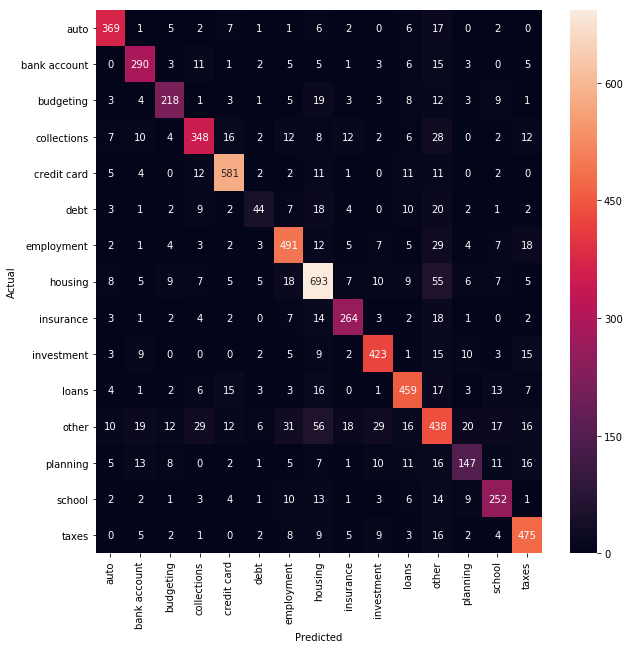

In [49]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=x, yticklabels=x)
plt.ylabel('Actual')
plt.xlabel('Predicted')
#plt.savefig(r'C:\Users\Joshua\Downloads\personal_finance_pics\PersonalFinance Linear SVC', bbox_inches = 'tight')
plt.show()

Using Linear Support Vector Classification resulted in an accuracy of 0.7582, precision of 0.76 and recall of 0.76. 

On paper this looks pretty good, especially compared to our baseline. If we take a look at the classification report, it's worthwhile noting that while some topics like credit card and debt had high precision rates, topics like other and bills did considerably poorly. Looking at the confusion matrix we can see why this is the case. There were many instances where 'other' posts were incorrectly labeled as investment, school, etc. On the flip side, there were many non-'other' posts that were incorrectly labeled as 'other' such as school, saving, and taxes. 

This could have been due to the fact that the other topic had many overlapping words and phrases with other topics. Another reason could have been due to the fact that more than 1 topic was classified under 'other', resulting in a mixture of differing words that are not quite coherent when used together.

Let's see if we can do better with logistic regression.

**Logistic Regression**

In [50]:
steps = [
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(n_jobs=1, random_state = 0))
]
logreg = Pipeline(steps)

param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2),(2,2)],
    'tfidf__use_idf': (True, False),
    'clf__C': [0.01, 0.1, 1, 10]
}

gs_logreg = GridSearchCV(logreg, param_grid, n_jobs=-1, scoring = 'accuracy', cv = 10)
gs_logreg.fit(X_train, y_train)

print('The best score is: {0:.4f}'.format(gs_logreg.best_score_))
print('The best parameters are:',gs_logreg.best_params_)

The best score is: 0.7961
The best parameters are: {'clf__C': 10, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}


In [106]:
# with open('pf_gs_logreg.pickle', 'wb') as f:
#     pickle.dump(gs_logreg, f)
# gs_logreg = pd.read_pickle('pf_gs_logreg.pickle')

In [6]:
best_logreg = gs_logreg.best_estimator_
y_pred = best_logreg.predict(X_test)
x = best_logreg.classes_
logreg_cv = cross_val_score(best_logreg,X,y,cv=10, scoring='accuracy')

print('Accuracy: {0:.4f}'.format(best_logreg.score(X_test, y_test))) 
print('Average 10-Fold Cross-Validation Accuracy Score: %s' % round(np.mean(logreg_cv), 4))
print('\nClassification Report:\n')
print(classification_report(y_test, y_pred, target_names=x))

Accuracy: 0.7976
Average 10-Fold Cross-Validation Accuracy Score: 0.8015

Classification Report:

              precision    recall  f1-score   support

        auto       0.87      0.88      0.87       419
bank account       0.83      0.84      0.84       350
   budgeting       0.81      0.72      0.76       293
 collections       0.82      0.75      0.78       469
 credit card       0.88      0.92      0.90       642
        debt       0.71      0.28      0.40       125
  employment       0.81      0.84      0.83       593
     housing       0.77      0.83      0.80       849
   insurance       0.82      0.80      0.81       323
  investment       0.84      0.87      0.85       497
       loans       0.83      0.85      0.84       550
       other       0.60      0.63      0.61       729
    planning       0.76      0.58      0.66       253
      school       0.80      0.77      0.78       322
       taxes       0.83      0.89      0.86       541

 avg / total       0.80      0.80   

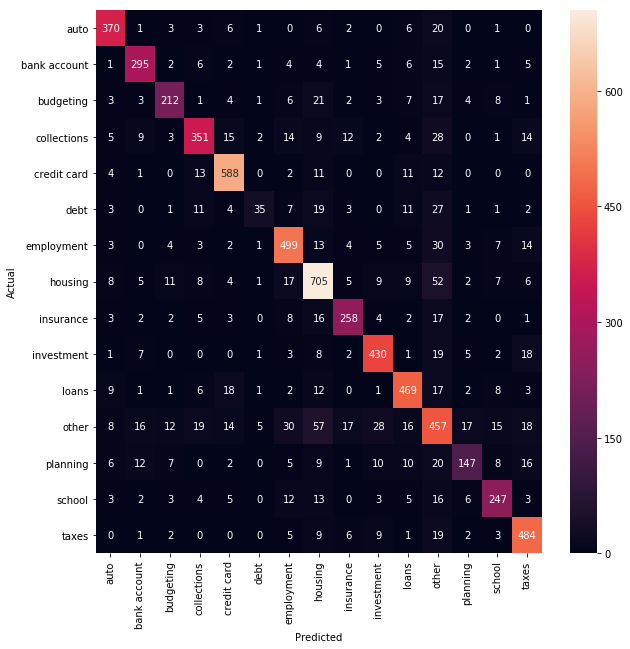

In [53]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=x, yticklabels=x)
plt.ylabel('Actual')
plt.xlabel('Predicted')
#plt.savefig(r'C:\Users\Joshua\Downloads\personal_finance_pics\PersonalFinance Logistic Regression', bbox_inches = 'tight')
plt.show()

The Logistic Regression model performed slightly better with an accuracy of 0.7655, precision of 0.78, and recall of 0.77. 

The 'other' topic did even worse in this model with a precision of 0.54 but there are more topics with higher precision. 

**Multinomial Naive Bayes**

In [54]:
steps = [
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
]
nb = Pipeline(steps)

param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2),(2,2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': [0.01, 0.1, 0.5, 1, 10]
}

gs_nb = GridSearchCV(nb, param_grid, n_jobs=-1, scoring = 'accuracy', cv = 10)
gs_nb.fit(X_train, y_train)

print('The best score is: {0:.4f}'.format(gs_nb.best_score_))
print('The best parameters are:',gs_nb.best_params_)

# with open('pf_gs_nb.pickle', 'wb') as f:
#     pickle.dump(gs_nb, f)
# gs_nb = pd.read_pickle('pf_gs_nb.pickle')

The best score is: 0.7408
The best parameters are: {'clf__alpha': 0.01, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1)}


In [56]:
best_nb = gs_nb.best_estimator_
y_pred = best_nb.predict(X_test)
x = best_nb.classes_

print('Accuracy: {0:.4f}'.format(best_nb.score(X_test, y_test))) 
nb_cv = cross_val_score(best_nb,X,y,cv=10, scoring='accuracy')
print('Average 10-Fold Cross-Validation Accuracy Score: %s' % round(np.mean(nb_cv), 4))
print('\nClassification Report:\n')
print(classification_report(y_test, y_pred, target_names=x))

Accuracy: 0.7318
Average 10-Fold Cross-Validation Accuracy Score: 0.7422

Classification Report:

              precision    recall  f1-score   support

        auto       0.87      0.88      0.87       419
bank account       0.81      0.68      0.74       350
   budgeting       0.76      0.62      0.68       293
 collections       0.71      0.74      0.73       469
 credit card       0.79      0.89      0.83       642
        debt       0.78      0.06      0.10       125
  employment       0.78      0.76      0.77       593
     housing       0.64      0.85      0.73       849
   insurance       0.91      0.66      0.76       323
  investment       0.80      0.80      0.80       497
       loans       0.73      0.78      0.75       550
       other       0.56      0.55      0.56       729
    planning       0.66      0.32      0.44       253
      school       0.79      0.66      0.72       322
       taxes       0.72      0.88      0.79       541

 avg / total       0.74      0.73   

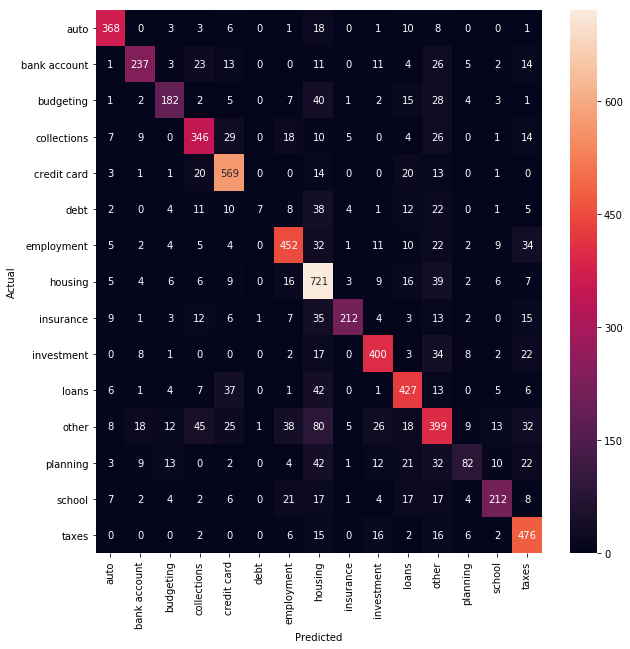

In [57]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=x, yticklabels=x)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The Multinomial Naive Bayes model performed relatively worse than the other 2 with an accuracy of 0.6753, precision of 0.70, and recall of 0.67. 

This is odd since multinomial naive bayes is often regarded as one of the best models to use for text classification problems. While most of the topics have only had moderate decreases in their precision scores, other decreased to an abysmal 0.39 precision score. When we look at the confusion matrix, we can see that many of the posts were incorrectly labeled as other. 55 were actually saving, 46 were actually taxes, and 40 were actually school. 

**Stochastic Gradient Descent**

In [58]:
steps = [
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2', max_iter = 5, random_state = 0, tol=None))
]
sgd = Pipeline(steps)

param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2),(2,2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': [0.001, 0.01, 0.1, 1, 10]
}

gs_sgd = GridSearchCV(sgd, param_grid, n_jobs=-1, scoring = 'accuracy', cv = 10)
gs_sgd.fit(X_train, y_train)

print('The best score is: {0:.4f}'.format(gs_sgd.best_score_))
print('The best parameters are:',gs_sgd.best_params_)

# with open('pf_gs_sgd.pickle', 'wb') as f:
#     pickle.dump(gs_sgd, f)
# gs_sgd = pd.read_pickle('pf_gs_sgd.pickle')

The best score is: 0.7208
The best parameters are: {'clf__alpha': 0.001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}


In [60]:
best_sgd = gs_sgd.best_estimator_
y_pred = best_sgd.predict(X_test)
x = best_sgd.classes_

print('Accuracy: {0:.4f}'.format(best_sgd.score(X_test, y_test))) 
sgd_cv = cross_val_score(best_sgd,X,y,cv=10, scoring='accuracy')
print('Average 10-Fold Cross-Validation Accuracy Score: %s' % round(np.mean(sgd_cv), 4))
print('\nClassification Report:\n')
print(classification_report(y_test, y_pred, target_names=x))

Accuracy: 0.7173
Average 10-Fold Cross-Validation Accuracy Score: 0.721

Classification Report:

              precision    recall  f1-score   support

        auto       0.69      0.90      0.78       419
bank account       0.72      0.77      0.75       350
   budgeting       0.80      0.51      0.62       293
 collections       0.78      0.53      0.63       469
 credit card       0.72      0.95      0.82       642
        debt       0.62      0.06      0.12       125
  employment       0.73      0.84      0.78       593
     housing       0.68      0.84      0.75       849
   insurance       0.75      0.72      0.74       323
  investment       0.72      0.86      0.78       497
       loans       0.72      0.84      0.78       550
       other       0.69      0.36      0.47       729
    planning       0.71      0.25      0.36       253
      school       0.79      0.56      0.65       322
       taxes       0.70      0.92      0.79       541

 avg / total       0.72      0.72    

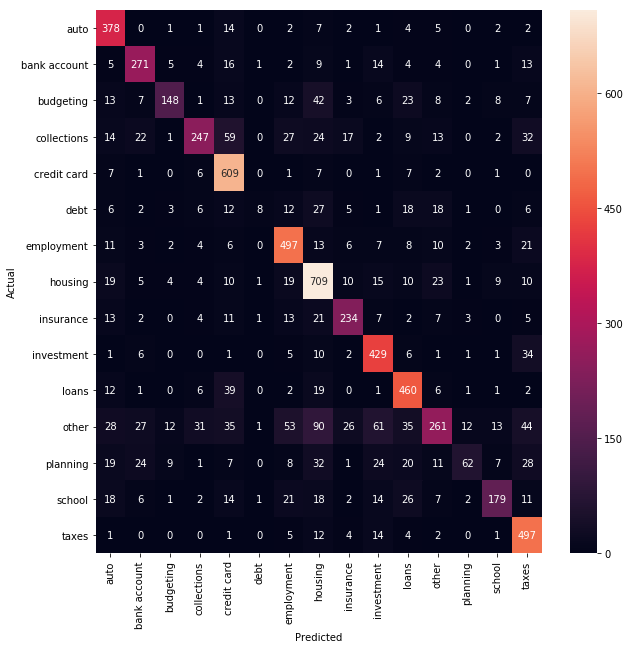

In [61]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=x, yticklabels=x)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The Stochastic Gradient Descent model performed better than the Multinomial NB model but still worse than the top 2. It had an accuracy of 0.6985, precision of 0.71, and recall of 0.71.

What's interesting is that while this model's precision score for 'other' was actually the best we have seen so far, its recall score has slightly suffered  with a score of 0.44. The confusion matrix shows that many housing posts were incorrectly labeled as auto, savings, etc. This trend continues for the other topics as well such as expenses (0.23 recall), loans (0.28) and other (0.34).

**Random Forest**

In [62]:
steps = [
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(random_state = 0))
]
rf = Pipeline(steps)

param_grid = {
    'clf__n_estimators': range(80,101),
    'clf__max_depth': range(1,51),
    'clf__min_samples_split': range(2,11),
    'clf__min_samples_leaf': range(1,5)
}

rs_rf = RandomizedSearchCV(rf, param_grid, n_iter = 20, n_jobs=-1, scoring = 'accuracy', cv = 10)
rs_rf.fit(X_train, y_train)

print('The best score is: {0:.4f}'.format(rs_rf.best_score_))
print('The best parameters are:',rs_rf.best_params_)

# with open('pf_rs_rf.pickle', 'wb') as f:
#     pickle.dump(rs_rf, f)
# rs_rf = pd.read_pickle('pf_rs_rf.pickle')

The best score is: 0.6470
The best parameters are: {'clf__n_estimators': 85, 'clf__min_samples_split': 6, 'clf__min_samples_leaf': 1, 'clf__max_depth': 43}


In [64]:
best_rf = rs_rf.best_estimator_
y_pred = best_rf.predict(X_test)
x = best_rf.classes_

print('Accuracy: {0:.4f}'.format(best_rf.score(X_test, y_test))) 
rf_cv = cross_val_score(best_rf,X,y,cv=10, scoring='accuracy')
print('Average 10-Fold Cross-Validation Accuracy Score: %s' % round(np.mean(rf_cv), 4))
print('\nClassification Report:\n')
print(classification_report(y_test, y_pred, target_names=x))

Accuracy: 0.6431
Average 10-Fold Cross-Validation Accuracy Score: 0.6504

Classification Report:

              precision    recall  f1-score   support

        auto       0.79      0.81      0.80       419
bank account       0.78      0.61      0.68       350
   budgeting       0.75      0.46      0.57       293
 collections       0.73      0.49      0.59       469
 credit card       0.71      0.92      0.81       642
        debt       1.00      0.02      0.03       125
  employment       0.71      0.72      0.72       593
     housing       0.61      0.70      0.65       849
   insurance       0.77      0.57      0.66       323
  investment       0.67      0.80      0.73       497
       loans       0.73      0.71      0.72       550
       other       0.31      0.48      0.38       729
    planning       0.87      0.08      0.14       253
      school       0.79      0.48      0.59       322
       taxes       0.69      0.81      0.75       541

 avg / total       0.68      0.64   

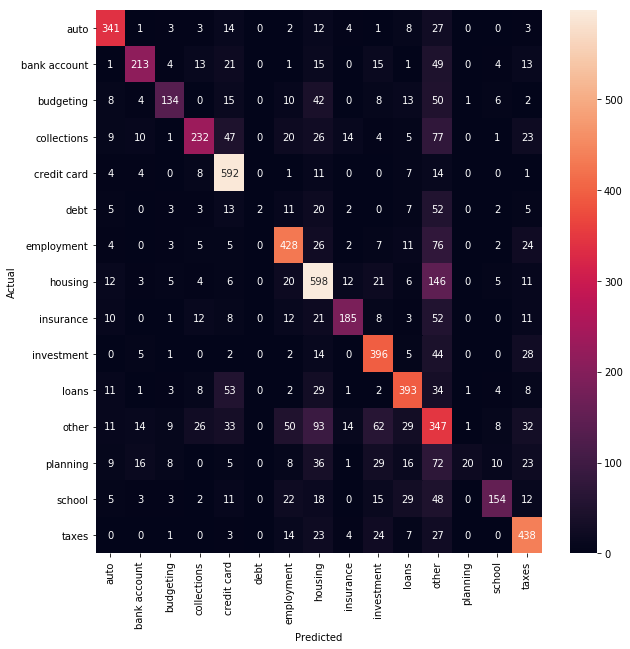

In [65]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=x, yticklabels=x)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The Random Forest model produced the worst results of the models with an accuracy of 0.6119, precision of 0.67, and recall of 0.62.

Once again, this model has a poor precision score for other as we've seen in the other models. However, it has extremely low recall scores particularly for bills (0.02), saving (0.07) and debt (0.16). A great number of posts were predicted as 'other' which caused these recall scores to be lower compared to the other models.

### Results

We ran 5 different type of models as well as a dummy model to use as a baseline. There were varying degrees of success and failure through each model. Let's look at the results!

In [66]:
# Empty list
entries = []

# Dictionary mapping the names of the models to the cv scores
models = {
    'Baseline': dummy_cv,
    'Linear SVC': svc_cv,
    'Logistic Regression': logreg_cv,
    'Multinomial NB': nb_cv,
    'Stochastic GD': sgd_cv,
    'Random Forest': rf_cv
}

# Append relevant information into the list
for model in models:
    for num, score in enumerate(models[model]):
        entries.append((model, num, score))
        
# Create dataframe
df_models = pd.DataFrame(entries, columns = ['model_name', 'k-fold number', 'accuracy'])

# df_models.to_pickle('pf_df_models')
# df_models = pd.read_pickle('pf_df_models')

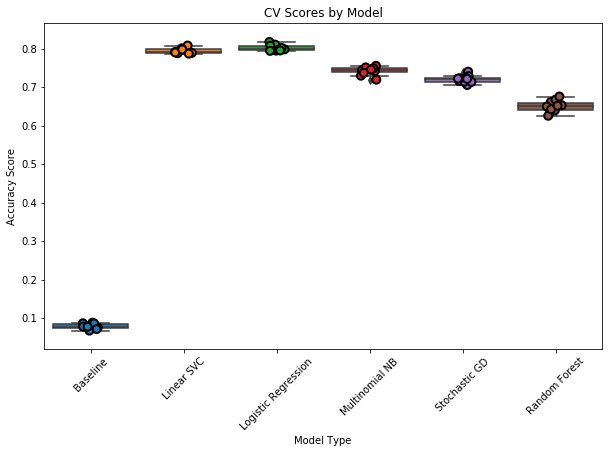

In [68]:
# Create a boxplot of each model's cross-validation results
plt.figure(figsize = (10,6))
sns.boxplot(x='model_name', y='accuracy', data=df_models)
sns.stripplot(x='model_name', y='accuracy', data=df_models, size=8, jitter=True, edgecolor="black", linewidth=2)
plt.title('CV Scores by Model')
plt.xlabel('Model Type')
plt.ylabel('Accuracy Score')
plt.xticks(rotation = 45)
#plt.savefig(r'C:\Users\Joshua\Downloads\personal_finance_pics\PersonalFinance Results Boxplot', bbox_inches = 'tight')
plt.show()

In [69]:
mean_accuracies = df_models.groupby('model_name')['accuracy'].mean().sort_values(ascending = False)
mean_accuracies

model_name
Logistic Regression    0.801480
Linear SVC             0.794535
Multinomial NB         0.742174
Stochastic GD          0.720988
Random Forest          0.650378
Baseline               0.078720
Name: accuracy, dtype: float64

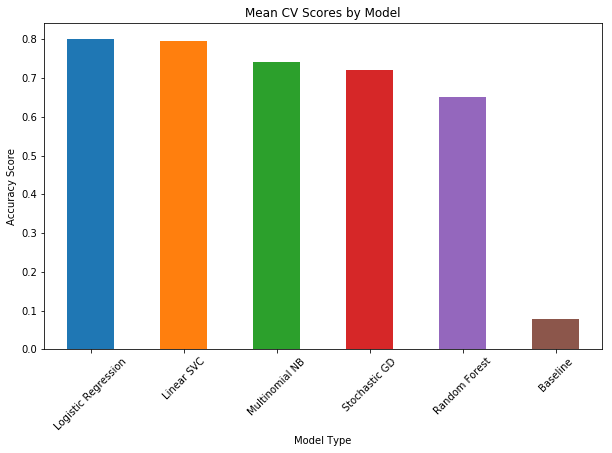

In [70]:
mean_accuracies.plot(kind='bar', figsize = (10,6))
plt.title('Mean CV Scores by Model')
plt.xlabel('Model Type')
plt.ylabel('Accuracy Score')
plt.xticks(rotation = 45)
#plt.savefig(r'C:\Users\Joshua\Downloads\personal_finance_pics\PersonalFinance Results Bar Graph', bbox_inches = 'tight')
plt.show()

Evidently, the Logistic Regression model was the best both in the mean 10-fold CV (0.7654) and the peak accuracy score (0.7845). However, the Linear SVC model is very close in accuracy as well. Multinomial Naive Bayes surprisingly did not perform that well considering its reputation as being one of the best for text classification purposes. 

When looking at the precision and recall scores for the Logistic Regression model, we could see that many of the topics did very well with scores above 0.8 and the high 0.7s. With the exception of the 'other topic (which we will discuss in the limitations section), it seems as though gensim's LDA algorithm did a fine job of creating the topics and choosing the 20 as the number of topics was the right choice. 

Topic-modeling is still very much a work-in-progress due to the fact that technology continues to adapt and evolve at a rapid pace. It especially requires an "eye-test" approach to refining and improving the models because text is not as easily interpreted by the machine compared to numbers. Therefore the user will need to verify whether or not the generated topics "work" by looking at several factors such as how much the topics make sense given the type of words that surround the topic, how many documents fit under each topic (if there are too many documents under 1 topic and too few under another, it is practically useless), etc. 

All in all, these results looked good considering the fact that the topics were generated by the machine rather than by humans. 

**Limitations of the Model**

One pattern we did notice throughout all the models is the fact that the 'other' topic did a very poor job in both precision and recall. In other words, the model often falsely labeled non-'other' posts as 'other' and also did not correctly label 'other' posts as 'other'. If we had to choose between avoiding a Type I error (misclassifying 'other' posts as not 'other') and a Type II error (misclassifying non-'other' posts as 'other'), the former would be preferred. This is because the topic 'other' is a mixture of several topics whereas the other topics have a stricter definition of what kinds of posts and words belong to that category. 

For example, if an 'auto' post about car insurance was labeled as 'other', it would not be as damaging as if an 'other' post about a grandmother leaving behind a will was labeled as 'school'. There are also cases where the author of the post does not know what the topic should be; in this situation, they would most likely categorize the post under "other" rather than falsely labeling it as something definitive in nature. In a sense, the 'other' topic could be seen as a wildcard when 

Another problem does not have to do so much with the classification model, but with the topic-modeling. There are certain cases where a post was labeled under a topic that does not make sense to a human observer. Because the machine makes its decisions using vectorized inputs, it is unable to accurately classify each post 100% of the time. As a result, there are some exceptions where the classification model actually "corrects" the topic-modeling mistakes and labels some posts with the "right" topic. One explanation for this limitation is the fact that each document (or post) is assigned a number of different topics and we simply chose the topic with the highest similarity percentage as the label. This may work well for most posts but there are scenarios where this line of thinking can backfire.

For example, what if a post about college loans had a 34% contribution from 'loans' but 33% contribution from 'school'? In this case, the model would categorize this post under the 'loans' topic but the classification model may predict it as 'school'. 

Let's take a look at a few examples of these incidents using the Logistic Regression model since it was the best one:

In [9]:
# Extract the predictions for the model
y_pred = best_logreg.predict(X_test)
# Store the confusion matrix into class_rep
conf_mat = confusion_matrix(y_test, best_logreg.predict(X_test))
# Get the list of classes in the model
classes = best_logreg.classes_
# Extract some of the cases where 'other' posts were misclassified as non-'other'
count = 0
for pred_num, pred_topic in enumerate(classes):
    for real_num, real_topic in enumerate(classes):
        if real_topic == 'other' and pred_topic != real_topic and conf_mat[real_num, pred_num] >= 10 and conf_mat[real_num, pred_num] <=20:
            if count <=2:
                print('"Other" missclassified as "{}": {} cases'.format(pred_topic, conf_mat[real_num, pred_num]))
                display(df_eval.loc[indices_test[(y_test == real_topic) & (y_pred == pred_topic)]][['new_topic', 'text']])
                count += 1
            else:
                break

"Other" missclassified as "bank account": 16 cases


,new_topic,text
520,other,Seeking advice about how to transfer inheritan...
9038,other,"I'm being paid internationally via Paypal, bes..."
15295,other,Education Savings Account over age 30 I have a...
15785,other,Need information on consolidating my retiremen...
12266,other,"Moving to France but being paid in USD, how do..."
210,other,Card app took payment twice If this is the wro...
18379,other,Is someone from India using my phone number fo...
6515,other,Getting paid in $USD We are Aussies. Living in...
15637,other,Can anyone reccomend me a really good savings ...
10072,other,What’s in your [digital] wallet? What apps are...


"Other" missclassified as "budgeting": 12 cases


,new_topic,text
14989,other,"[Other] I feel like I focused on saving money,..."
3689,other,I Need Help Finding a System of Budgeting That...
10061,other,"Stripper with goals! \n\nThrowaway, because r..."
9812,other,How to budget $1400 as a teenager.
20066,other,Got married! More automated way of measuring f...
18377,other,My gym membership is running out in three days
20019,other,"Free budget software? Hi guys, long time lurke..."
18308,other,Any free sites where I can make a budgeting sp...
18429,other,24 y/o trying to get ahead early: how should I...
3508,other,Need honest critique/rating on my financial si...


"Other" missclassified as "collections": 19 cases


,new_topic,text
18862,other,Had a merchant tell me they wouldnâ€™t accept ...
17723,other,"Primera Air Collapse, Possible to chargeback o..."
4194,other,Was this a scam? Can you solve the puzzle? So ...
12783,other,Do I charge sales tax doing a service for peop...
16246,other,False location advertising on AirBnB. Do I hav...
4685,other,My rental company is not replying to workorder...
17325,other,Advice needed for an online purchase Iam sorry...
11571,other,Debt settlement? Hey everyone. Im in a bind an...
18669,other,For tax or other reasons does it matter if a d...
8956,other,"Capital One ATM Miscounted/ate my money, a mon..."


We can see that with the Type I error, there are a few examples where misclassifying 'other' as a different topic could be off the mark.

For row #1360", it wouldn't make sense for a post about Acorn, an investment platform, to be classified under the topic 'collections'. Similarly, row #9165 concerns crypto-currency (which could be attributed to a variety of different topics) and is classified under 'expenses'. 

On the other hand, we can also see that some of these misclassifications are actually "corrections". 

For example, row #8767 is very clearly about school and therefore should be labeled under 'school' despite actually being labeled as 'other'. This is a case where the LDA algorithm did not do a good job of correctly identifying the appropriate topic for the row. 

Next, let's observe the Type II errors where non-'other' posts were incorrectly predicted as 'other'.

In [72]:
# Extract some of the cases where non-'other' posts were misclassified as'other'
count = 0
for pred_num, pred_topic in enumerate(classes):
    for real_num, real_topic in enumerate(classes):
        if pred_topic == 'other' and pred_topic != real_topic and conf_mat[real_num, pred_num] >= 10 and conf_mat[real_num, pred_num] <=20:
            if count <=2:
                print('"{}" missclassified as "other": {} cases'.format(real_topic, conf_mat[real_num, pred_num]))
                display(df_eval.loc[indices_test[(y_test == real_topic) & (y_pred == pred_topic)]][['new_topic', 'text']])
                count += 1
            else:
                break

"auto" missclassified as "other": 20 cases


,new_topic,text
866,auto,"How to fix that hole in my pocket? Hi, I’m a 2..."
5098,auto,"I bought a brand new car, and I just realized ..."
6245,auto,Feeling underwater with finances and debt.
4269,auto,"House needs repairs, not sure best method of p..."
17799,auto,I need advice on getting out from an auto loan...
22731,auto,Has anyone had a warranty buy a appliance back...
563,auto,I just heavily damaged my car against a pillar...
22037,auto,A few months ago I posted about a financial wr...
13101,auto,Seeking advice after falling for a towing scam...
19365,auto,Buy van with cash vs finance As the title stat...


"bank account" missclassified as "other": 15 cases


,new_topic,text
15230,bank account,LOOKING FOR FINANCIAL PLANNING APPS
21999,bank account,Question about RBC investments I read a post a...
22112,bank account,"17, illegal, pay check to pay check, no future."
22692,bank account,(BD) How do I adjust discrepancies between my ...
5068,bank account,Employer wants me to pay urgent expense in cas...
15837,bank account,"Inherited IRA/Brokerage Account, Uneducated an..."
7406,bank account,I am trying to run a small online business for...
18883,bank account,"Today, barclaycardus.com suddenly began requir..."
6481,bank account,"What Would You Do - Cashing out ""news to me!"" ..."
15221,bank account,Balanging your checkbook - outdated and useles...


"budgeting" missclassified as "other": 17 cases


,new_topic,text
13933,budgeting,"401k ""Plan Expense Payment"""
5925,budgeting,When to allow yourself an unnecessary expense ...
20987,budgeting,International student in USA (VA). First time ...
20554,budgeting,Cashless payments are making us spend more
14738,budgeting,"I have 100,000 dollars and no debt. What do I ..."
4989,budgeting,Deducting Business Expenses on Taxes Hello! My...
5384,budgeting,Can anyone give me the formula used on this in...
1530,budgeting,Need advice. Got 1.3M coming my way by EOY
11143,budgeting,Need an app to track daily income! Hey guys I ...
17536,budgeting,I think my Boss might throw me under the bus


In the case of the Type II error, some of the misclassifications were not entirely wrong from a human-perspective. 

For example, let's take a look at the examples where "auto" posts were misclassified as "other". For post #6599, the topic is very unclear since the text only says "Can you guys help?". In this situation, humans can interpret that as going under the topic "other" since it wouldn't make sense to put it under other topics. However, the machine initially classified it as "auto", which shows an example where the LDA algorithm actually made a mistake and the classification model "corrected" it after training.

In summary, there were certainly many positives to take away from this model, particularly the high accuracy and precision rates of the Logistic Regression and Linear SVC models. The main topics certainly performed well due to the fact that the *majority* of the posts fit into one topic rather well. On the other hand, there were still a few inadequacies that occured during the topic-modeling stage that slightly dulled the effectiveness of the predictive model. This is shown through the fact that the 'Other' topic mainly consisted of ambiguous words that could be seen in any post regardless of their subject. 